In [169]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime


from sklearn.metrics import accuracy_score
from sklearn import metrics


In [2]:
data_encoded = pd.read_csv('../data/processed/heart_attack_prediction_dataset_encoded.csv')

In [3]:
data_encoded.head()

,Cholesterol,Diabetes,Exercise Hours Per Week,Triglycerides,Systolic,Age,Previous Heart Problems,Medication Use,Heart Attack Risk,Cholesterol Level_At Risk,Cholesterol Level_Dangerous,Cholesterol Level_Hearty Health,Blood Pressure_Elevated,Blood Pressure_Healthy,Blood Pressure_Hypertension Crisis,Blood Pressure_Stage 1 Hypertension,Blood Pressure_Stage 2 Hypertension
0,208,0,4.168,286,158,67,0,0,0,1,0,0,0,0,0,0,1
1,389,1,1.813,235,165,21,1,0,0,0,1,0,0,0,0,0,1
2,324,1,2.078,587,174,21,1,1,0,0,1,0,0,0,0,0,1
3,383,1,9.828,378,163,84,1,0,0,0,1,0,0,0,0,0,1
4,318,1,5.804,231,91,66,1,0,0,0,1,0,0,1,0,0,0


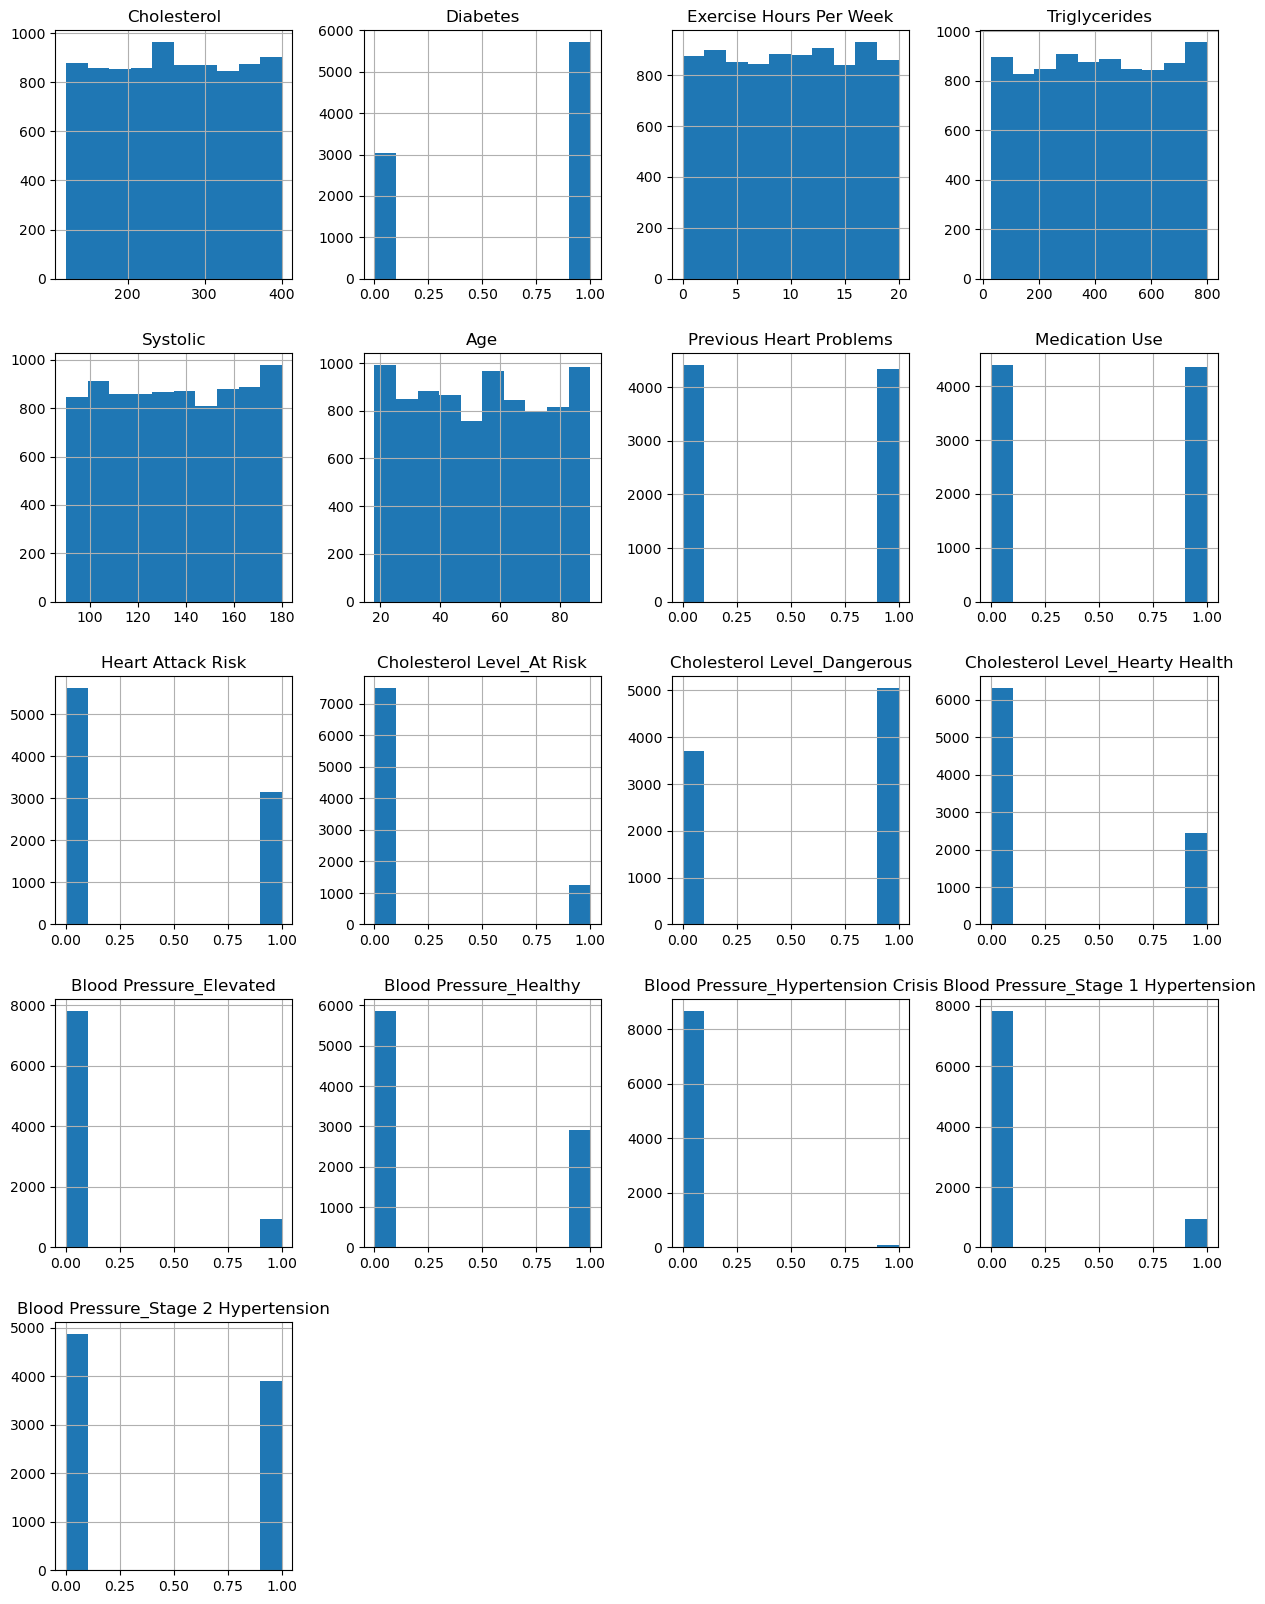

In [4]:
data_encoded.hist(figsize=(15, 20))
plt.show()

In [64]:
X = data_encoded.drop("Heart Attack Risk", axis=1)
y = data_encoded["Heart Attack Risk"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Initial Not-Even-A-Model

In [8]:
train_mean = y_train.mean()
train_mean

0.35881969351157483

In [9]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[0.35881969]])

In [10]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([0.35881969, 0.35881969, 0.35881969, 0.35881969, 0.35881969])

In [11]:
y_te_pred = train_mean * np.ones(len(y_test))
y_te_pred[:5]

array([0.35881969, 0.35881969, 0.35881969, 0.35881969, 0.35881969])

In [12]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -1.7957412854707755e-05)

In [13]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.4601362421196687, 0.459563038879504)

In [14]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.23006812105983435, 0.2294949178196696)

## Linear Regression

#### Define Pipeline

In [82]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

#### Fit_the_pipeline

In [175]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000018FFD7B44A0>)),
                ('linearregression', LinearRegression())])

#### Assess performance on the train and test set

In [ ]:
y_tr_pred = lr_pipe.predict(X_train)
y_te_pred = lr_pipe.predict(X_test)

In [153]:
# A lower MAE indicates better model performance
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.4591467550335904, 0.45909054797679455)

In [161]:
#  A lower MSE indicates better model performance.
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.2295733775167952, 0.2295175918277474)

In [171]:
# A lower RMSE indicates better model performance.
root_mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.47913816119862046, 0.2295175918277474)

In [165]:
#R² values range from 0 to 1 (or 0% to 100%), where:
#0 indicates the model does not explain any variability. 
#1 indicates the model perfectly explains all the variability. 
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0021504219739789665, -0.00011675879573380676)

#### Fit_and_assess_performance_using_cross-validation

In [184]:
rf_default_cv_results = cross_validate(lr_pipe, X_train, y_train, cv=5)

In [186]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.00629444, -0.0061884 , -0.00371527, -0.00302691, -0.00312024])

In [188]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.004469049768732303, 0.0014666604083637793)

#### Hyperparameter search using GridSearchCV

In [84]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [86]:
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [127]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000018FFD7B44A0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16]})

In [190]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
print(score_mean)
print(score_std)
np.mean(score_mean), np.std(score_std)

[-0.00245477 -0.0036052  -0.00385516 -0.00348503 -0.00355333 -0.00349041
 -0.0036981  -0.00383031 -0.00450747 -0.00446905 -0.00449027 -0.00440553
 -0.00450423 -0.00453491 -0.00454563 -0.00452972]
[0.00232262 0.0021961  0.00169695 0.00144477 0.00159414 0.00133832
 0.00093411 0.00122072 0.00121438 0.00146666 0.00140916 0.00154367
 0.00196224 0.00193048 0.00189467 0.00190212]


(-0.003997444847487902, 0.0003689102837325573)

In [198]:
lr_grid_cv.scorer_

<class 'sklearn.pipeline.Pipeline'>.score

In [147]:
# Mean cross-validated score of the best_estimator
print(lr_grid_cv.best_score_, "\n", lr_grid_cv.best_params_)

-0.0024547662410511427 
 {'selectkbest__k': 1}


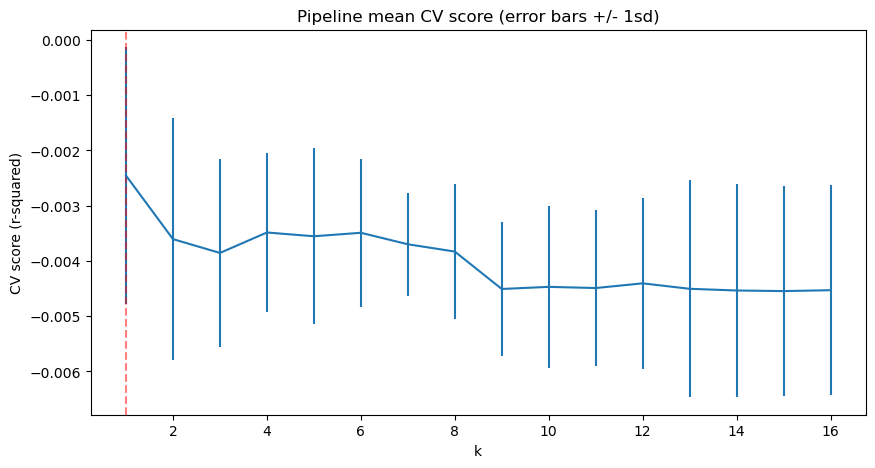

In [149]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [31]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False])

In [151]:
lr_grid_cv.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=1,
                             score_func=<function f_regression at 0x0000018FFD7B44A0>)),
                ('linearregression', LinearRegression())])

In [32]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Blood Pressure_Hypertension Crisis    0.014516
dtype: float64

## Logistic Regression

In [34]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
# Import modules
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer

# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [35]:
pipe16 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    LogisticRegression()
)
pipe16

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [36]:
# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=10)
# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)
# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

0.6411802949141862 
 {'logreg__C': 0.001}


In [37]:
sns.color_palette("pastel")

y_pred = cv.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=1))

# Visualize the confusion matrix
#sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='d')
#plt.show()

Accuracy: 0.6432103461392165
Confusion Matrix:
 [[1691    0]
 [ 938    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1691
           1       1.00      0.00      0.00       938

    accuracy                           0.64      2629
   macro avg       0.82      0.50      0.39      2629
weighted avg       0.77      0.64      0.50      2629



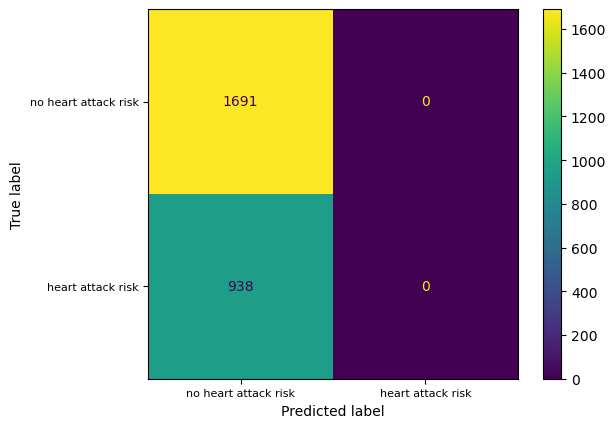

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(y_test, y_pred)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no heart attack risk', 'heart attack risk'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart attack risk', 'heart attack risk'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart attack risk', 'heart attack risk'], fontsize = 8)
display_cm.plot(ax = ax)
plt.show()

## Random Forest 

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.626
Random Forest: f1-score=0.545


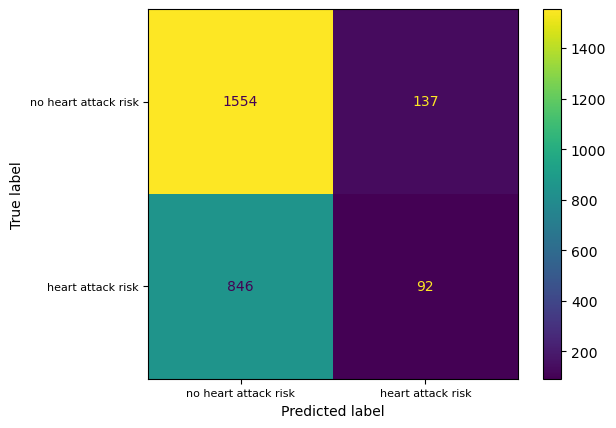

In [41]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no heart attack risk', 'heart attack risk'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart attack risk', 'heart attack risk'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart attack risk', 'heart attack risk'], fontsize = 8)
display_cm.plot(ax = ax)
plt.show()

### KNeighbors Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [44]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.6374307818509848
Best Parameters: {'n_neighbors': 44}


In [45]:
y_pred = knn_cv.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

In [46]:
y_test

1226    0
7903    1
1559    1
3621    1
7552    0
       ..
7864    1
380     1
4657    1
8521    0
1912    0
Name: Heart Attack Risk, Length: 2629, dtype: int64

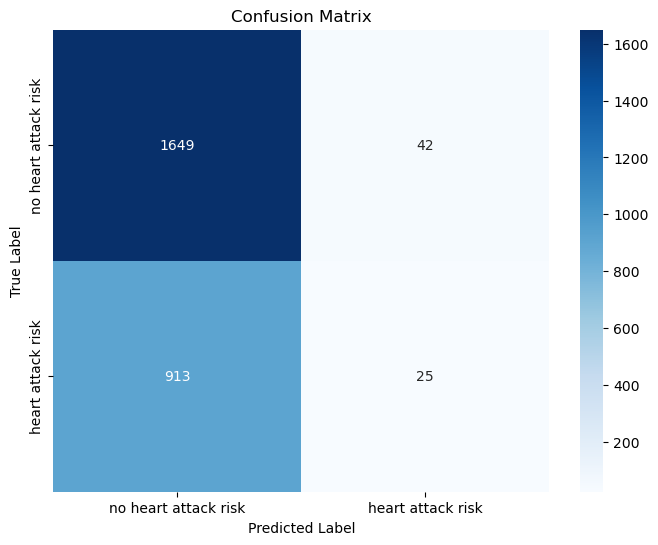

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(pl, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no heart attack risk', 'heart attack risk'], 
            yticklabels=['no heart attack risk', 'heart attack risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree Classifier

In [49]:
from sklearn.tree import DecisionTreeClassifier

# Define the Decision Tree model
model = DecisionTreeClassifier()

# Create the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV model
grid_search.fit(X_train, y_train)

# Print the best parameters and best accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best Accuracy: 0.6379203112141048


In [50]:
#y_pred = pd.Series(y_pred)

In [51]:


# Evaluate the best model
#accuracy_best = accuracy_score(y_test, y_pred)

#print(f"Best Model Accuracy: {accuracy_best}")
#create array of probabilities
#y_test_predict_proba = tree1.predict_proba(X_test)

# calc confusion matrix
y_test_predict = grid_search.predict(X_test)
print("Confusion Matrix Tree : \n", confusion_matrix(y_test, y_test_predict),"\n")
#print("The precision for Tree is ",precision_score(y_test, y_test_predict)) 
#print("The recall for Tree is ",recall_score(y_test, y_test_predict),"\n")  

Confusion Matrix Tree : 
 [[1675   16]
 [ 930    8]] 



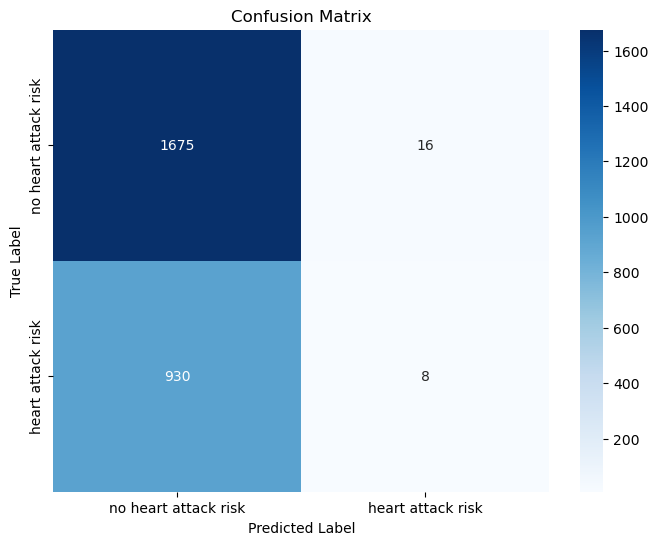

In [52]:
pl = confusion_matrix(y_test,y_test_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(pl, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no heart attack risk', 'heart attack risk'], 
            yticklabels=['no heart attack risk', 'heart attack risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

gb_model = GradientBoostingClassifier()

# A sample parameter
# n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

#passing the scoring function in the GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
#print("Best Score:" + str(clf.best_score_))
#print("Best Parameters: " + str(clf.best_params_))

In [56]:
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)

# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Best Model Accuracy: 0.6432103461392165


In [ ]:
y_pred

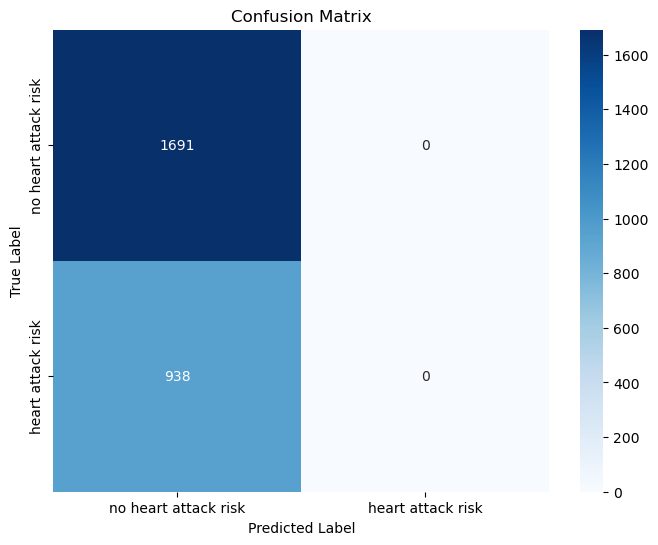

In [58]:
pl = confusion_matrix(y_test,y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(pl, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no heart attack risk', 'heart attack risk'], 
            yticklabels=['no heart attack risk', 'heart attack risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()